In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "4"

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
code_dir = "/home/mlmi-2020/jz522/localisation_from_image_project/code_reg_and_clas"
import os, sys
if code_dir not in sys.path:
    sys.path.append(code_dir)
    
from utilis.callbacks import Visualise_learning_reg_and_class

# Data Generator

In [4]:
class DataGenerator(keras.utils.Sequence):
    """ Loads, downsamples, crops, and auguments images and labels """
    
    def __init__(self, npz_file_IDs, batch_size=8, dim=(256,512), num_regions=20, shuffle=True, num_crops=1):

        self.npz_file_IDs = npz_file_IDs
        self.batch_size = batch_size
        self.dim = dim
        self.num_regions = num_regions
        self.shuffle = shuffle
        self.on_epoch_end()
        self.num_crops = num_crops

    
    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.npz_file_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
            
            
    def load_data(self, npz_file_ID_temp):
        """ Load .npz files with images and labels from self.room_dir """
        images = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        local_scene_coords = np.empty((self.batch_size, *self.dim, 3), dtype=np.float32)
        region_labels = np.empty((self.batch_size, *self.dim, 1), dtype=np.float32)
        masks = np.empty((self.batch_size, *self.dim, 1), dtype=np.int16)

        for i, ID in enumerate(npz_file_ID_temp):
            npz_data = np.load(ID)
            
            images[i] = npz_data['image_colors']
            local_scene_coords[i] = npz_data['local_scene_coords']
            region_labels[i] = np.expand_dims(npz_data['points_region_class'], axis=-1)
            masks[i] = np.expand_dims(npz_data['mask'], axis=-1).astype(int)

        return images, local_scene_coords, region_labels, masks

    
    def crop(self, data, start_row, start_col, data_depth):
        """ Images are equirectangular (360 projected onto a rectangle).
        Therefore we have to allow for all possibe crops, including these that run across the right image edge. """

        data_croped = np.zeros((self.batch_size, 224, 224, data_depth))

        for ind in range(self.batch_size):

            if start_col[ind] + 224 > 512:
                dif = start_col[ind] + 224 - 512
                wraped_data = data[ind, start_row[ind]:start_row[ind]+224, :dif,:]
                
                data_croped[ind] = np.concatenate(
                    (data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], 
                        wraped_data), axis=1)
                               
            else:
                data_croped[ind] = data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]

        return data_croped
    
    
    def get_crops(self, images, coords, regions, mask):
        
        # pick the start cordinates of croped images
        start_row = [0] #np.random.randint(0, high=self.dim[0]-224, size=self.batch_size)
        start_col = [50] # np.random.randint(0, high=self.dim[1], size=self.batch_size)
        
        image_crops = self.crop(images, start_row, start_col, data_depth=3)
        coords_crops = self.crop(coords, start_row, start_col, data_depth=3)
        region_crops = self.crop(regions, start_row, start_col, data_depth=1)
        mask_crops = self.crop(mask, start_row, start_col, data_depth=1)
        
        return image_crops, coords_crops, region_crops, mask_crops
    
    
    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.npz_file_IDs) / self.batch_size))
    
     
    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.npz_file_IDs[k] for k in indexes]

        # load
        images, local_scene_coords, region_labels, masks = self.load_data(list_IDs_temp)

        # crop
        images, local_scene_coords, region_labels, masks = self.get_crops(images, local_scene_coords, region_labels, masks)

        
        # one-hot encode labels
#         region_labels = (np.arange(self.num_regions) == region_labels[:,:,:,0][...,None]).astype(int)


        # expand dimension of mask
        nested_masks = [masks for _ in range(3)]
        mask_expanded = np.concatenate(nested_masks, axis=-1)

        # apply mask to 3D coords ground truth data
        local_scene_coords = local_scene_coords * mask_expanded
                               
        # coccatenate to images
        labels = np.concatenate((local_scene_coords, region_labels), axis=-1)

        return [images, mask_expanded], labels

In [5]:
generator_configs = {'batch_size': 1, 
                     'dim': (256,512),
                     'num_regions': 141, 
                     'shuffle': True, 
                     'num_crops': 1}

data_partition = ["/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete_working_141_classes/0001_rendered.png_config.npz"]

train_generator = DataGenerator(data_partition, **generator_configs)

# MSE callback

In [6]:
class pixelwise_MSE(keras.callbacks.Callback):
    def __init__(self, datapoint_name, frequency, start_row=[0], start_col=[50]):
        super(pixelwise_MSE, self).__init__()
        
        data = self.load_data(datapoint_name, start_row, start_col)
        
        self.image = data['image']
        self.oracle_global_coords = data['points_3d_world']  # i will use this to check whether i'm converting the data correctly
        self.mask = data['mask']
        self.W_inv = data['W_inv']
        self.M = data['M']
        self.std = data['std']
        
        self.frequency = frequency
        
        
      
    def crop(self, data, start_row, start_col, data_depth):
        num_crops = len(start_row)
        data_croped = np.zeros((num_crops, 224, 224, data_depth))

        for ind in range(num_crops):
            if start_col[ind] + 224 > 512:
                dif = start_col[ind] + 224 - 512
                wraped_data = data[ind, start_row[ind]:start_row[ind]+224, :dif,:]
                
                data_croped[ind] = np.concatenate(
                    (data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:], 
                        wraped_data), axis=1)  
            else:
                data_croped[ind] = data[ind, start_row[ind]:start_row[ind]+224, start_col[ind]:start_col[ind]+224,:]

        return data_croped
    
    
    def load_data(self, data_filename, start_row, start_col):
        data = np.load(data_filename)

        image = self.crop(  np.expand_dims(data['image_colors'], axis=0), start_row, start_col, 3)
        points_3d_world = self.crop(  np.expand_dims(data['points_3d_world'], axis=0), start_row, start_col, 3)
        mask = self.crop(  np.expand_dims(data['mask'], axis=[0,-1]), start_row, start_col, 1)
        
        W_inv = data['W_inv']
        M = data['M']
        std = data['std']
        
        
        return {'image': image,
                'points_3d_world': points_3d_world, 
                'mask': mask,
                'W_inv': W_inv,
                'M': M, 
                'std': std}
    
        
    def on_epoch_begin(self, epoch, logs=None):
        if(epoch%self.frequency == 0):

            output = self.model.predict([self.image, self.mask])
            global_coords = np.zeros((224*224,3))
            
            # 1. convert regions to their mean centers
            pred_local_coords = np.reshape(output[:,:,:,:3], (-1,3))
            labels = np.argmax(output[:,:,:,3:], axis=-1)
            pred_regions = np.reshape(labels, (-1)).astype(int)
                       
          
            # 2. unwhitten local coordinates
            for region in np.unique(pred_regions):
                region_coords = pred_local_coords[pred_regions == region]
                unwhite_loc_coords = np.dot(region_coords * self.std[region] , self.W_inv[region]) + self.M[region]
                
                global_coords[pred_regions == region] = unwhite_loc_coords
            
           
            # 4. compute MSE
            global_coords = np.reshape(global_coords, (224,224,3))
            global_coords = global_coords * self.mask[0]
            oracle = self.oracle_global_coords[0] * self.mask[0]
            euc_dist = np.mean(np.square(oracle - global_coords), axis=-1)
            print('MSE: ', np.mean(euc_dist))
            
            
            # 5. plot for visualisation
            
#             fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))
#             region_centers = self.M[pred_regions]
#             max_ = max(self.oracle_global_coords[0].max(), global_coords.max())
#             min_ = min(self.oracle_global_coords[0].min(), global_coords.min())
            
#             oracle_coords_norm = (self.oracle_global_coords[0] - min_) / (max_ - min_)
#             ax1.imshow(oracle_coords_norm)
#             ax1.set_title("Ground truth - global scene coords")
            
#             pred_coords_norm = (global_coords - min_) / (max_ - min_)
#             ax2.imshow(pred_coords_norm)
#             ax2.set_title("Pred - global scene coords")
            
#             region_centers = np.reshape(region_centers, (224,224,3))
# #             reg_cent_norm = (region_centers - min_) / (max_ - min_)
#             ax3.imshow(region_centers)
            
#             im4 = ax4.imshow(euc_dist)
#             ax4.set_title("Euclidean distance")
            
#             divider = make_axes_locatable(ax4)
#             cax = divider.append_axes('right', size='5%', pad=0.1)
#             cbar = fig.colorbar(im4, cax=cax)

            plt.show()
            

# Loss func

In [7]:
def combined_loss(y_true, y_pred):
    " combined loss for 3D local coordinate regression and Classification"

    beta = 0.5
    
    regr_true = y_true[:,:,:,:3]
    clas_true = y_true[:,:,:,3:]    
    regr_pred = y_pred[:,:,:,:3]
    clas_pred = y_pred[:,:,:,3:]

    regr_loss = tf.keras.losses.mean_squared_error(regr_true, regr_pred)
    regr_loss = tf.reduce_mean(regr_loss)

#     clas_loss = tf.keras.losses.categorical_crossentropy(clas_true, clas_pred)  # 1-hot-encoded labels
    clas_loss = tf.keras.losses.sparse_categorical_crossentropy(clas_true, clas_pred)  # categorical labels 
    clas_loss = tf.reduce_mean(clas_loss)
    
    loss = 10*regr_loss + 1*clas_loss
    return loss

# Setup model

In [8]:
# from models.unet_resnet_compat import vgg_unet

# unet_model = vgg_unet(num_regions=141)
# unet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combined_loss)

In [9]:
from models.fpn import resnet_fpn

unet_model = resnet_fpn(num_regions=141)
unet_model.compile(optimizer=keras.optimizers.Adam(1e-4), loss=combined_loss)

Running: VGG-16 backbone


In [10]:
unet_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 112, 112, 64) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

# Fit model

In [11]:
[images, mask], labels = train_generator.__getitem__(0)

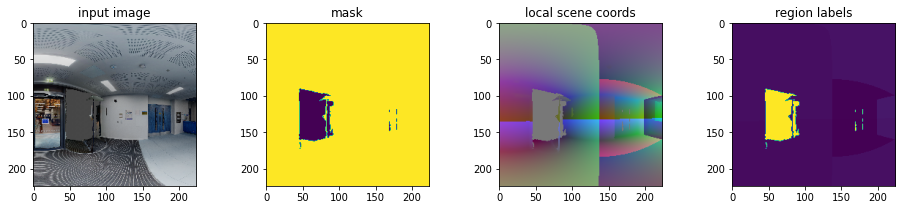

In [12]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))

ax1.imshow(images[0])
ax1.set_title("input image")

ax2.imshow(mask[0,:,:,0])
ax2.set_title("mask")

# only use two lines below if input is unnormalised
local_coords_norm = (labels[0,:,:,:3] - labels[0,:,:,:3].min()) / (labels[0,:,:,:3].max() - labels[0,:,:,:3].min())
ax3.imshow(local_coords_norm)
ax3.set_title("local scene coords")

# ax4.imshow(np.argmax(labels[0,:,:,3:], axis=-1))
ax4.imshow(labels[0,:,:,3:])
ax4.set_title("region labels")
plt.show()

In [13]:
np.unique(labels[0,:,:,3:])

array([  0.,   1.,   4.,   5.,   6.,   7.,   8.,   9., 140.])

**Note:** you can see mask on visualisation of local scene coords. The mask has been already applied in the data generator. In prediction visualisation mask will also have been applied in the network.

**Note2:** it is VERY IMPORTANT to have normalised labels. Otherwise it is harder to optimise the model (i wasn't able to train it).

In [14]:
file_name = "/data/cornucopia/jz522/localisation_project/DS_003_JDB-Full/coordinates_256_512_complete_working_141_classes/0001_rendered.png_config.npz"
global_coord_mse_callback = pixelwise_MSE(file_name, 1)
train_vis = Visualise_learning_reg_and_class(images[0], mask[0], labels[0,:,:,:3], labels[0,:,:,3:], 
                                            50, "/data/cornucopia/jz522/experiments/", "temp_testing", "train/")

callbacks = [global_coord_mse_callback, train_vis] 

MSE:  205.18680600153016

 ###     TRAIN      ###


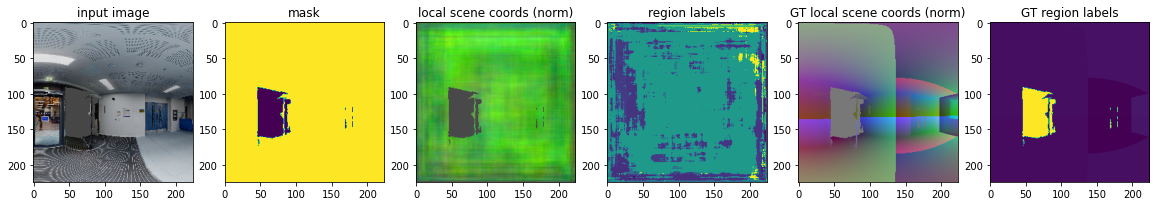

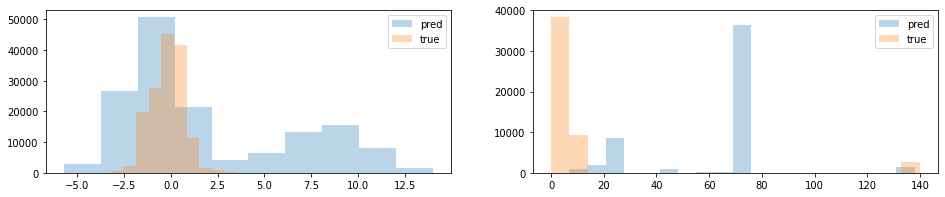

Epoch 1/500
1/1 [==============================] - 0s 3ms/step - loss: 28.5826
MSE:  136.15945629766708
Epoch 2/500
1/1 [==============================] - 0s 2ms/step - loss: 19.5624
MSE:  104.43794574318134
Epoch 3/500
1/1 [==============================] - 0s 2ms/step - loss: 15.0388
MSE:  88.74338900298723
Epoch 4/500
1/1 [==============================] - 0s 3ms/step - loss: 12.1676
MSE:  81.05897160570213
Epoch 5/500
1/1 [==============================] - 0s 2ms/step - loss: 10.5006
MSE:  80.65990666389276
Epoch 6/500
1/1 [==============================] - 0s 2ms/step - loss: 9.7195
MSE:  84.23076418153117
Epoch 7/500
1/1 [==============================] - 0s 3ms/step - loss: 9.4191
MSE:  85.56811858643408
Epoch 8/500
1/1 [==============================] - 0s 2ms/step - loss: 9.2632
MSE:  83.31706843695703
Epoch 9/500
1/1 [==============================] - 0s 3ms/step - loss: 9.0623
MSE:  75.74206639677497
Epoch 10/500
1/1 [==============================] - 0s 2ms/step - loss: 8.7

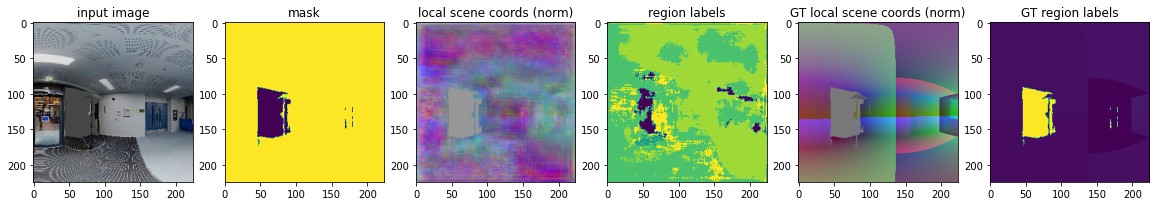

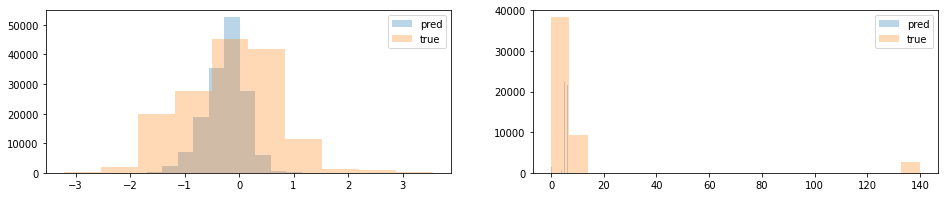

Epoch 51/500
1/1 [==============================] - 0s 2ms/step - loss: 2.4834
MSE:  2.534458121606108
Epoch 52/500
1/1 [==============================] - 0s 3ms/step - loss: 2.4091
MSE:  2.5408432786329946
Epoch 53/500
1/1 [==============================] - 0s 2ms/step - loss: 2.3379
MSE:  2.5467744240393713
Epoch 54/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2699
MSE:  2.5508306982191815
Epoch 55/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2050
MSE:  2.549498190838548
Epoch 56/500
1/1 [==============================] - 0s 2ms/step - loss: 2.1429
MSE:  2.5453259203168654
Epoch 57/500
1/1 [==============================] - 0s 3ms/step - loss: 2.0837
MSE:  2.543520878930694
Epoch 58/500
1/1 [==============================] - 0s 2ms/step - loss: 2.0275
MSE:  2.539162541482007
Epoch 59/500
1/1 [==============================] - 0s 2ms/step - loss: 1.9740
MSE:  2.5358887956950644
Epoch 60/500
1/1 [==============================] - 0s 3ms/step - lo

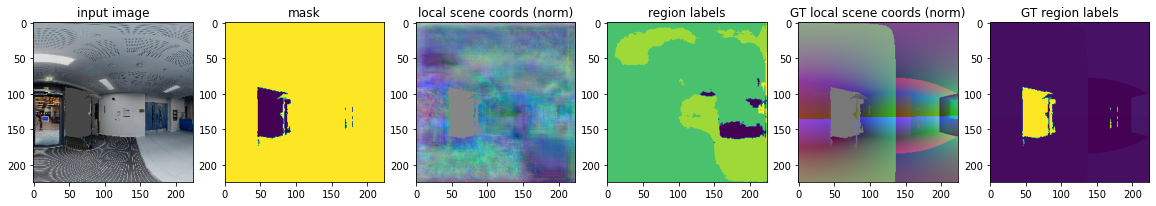

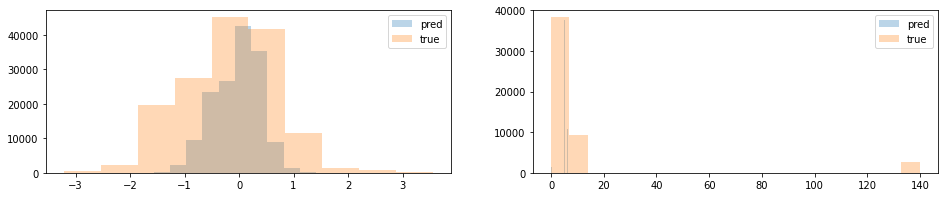

Epoch 101/500
1/1 [==============================] - 0s 1ms/step - loss: 0.8037
MSE:  1.8454120812011476
Epoch 102/500
1/1 [==============================] - 0s 2ms/step - loss: 0.7885
MSE:  1.8262669984454176
Epoch 103/500
1/1 [==============================] - 0s 3ms/step - loss: 0.7737
MSE:  1.8071789784089587
Epoch 104/500
1/1 [==============================] - 0s 2ms/step - loss: 0.7593
MSE:  1.7919176189049524
Epoch 105/500
1/1 [==============================] - 0s 2ms/step - loss: 0.7453
MSE:  1.7780071839496905
Epoch 106/500
1/1 [==============================] - 0s 3ms/step - loss: 0.7317
MSE:  1.763220531647848
Epoch 107/500
1/1 [==============================] - 0s 3ms/step - loss: 0.7184
MSE:  1.7476961271968854
Epoch 108/500
1/1 [==============================] - 0s 2ms/step - loss: 0.7055
MSE:  1.7330204283678399
Epoch 109/500
1/1 [==============================] - 0s 2ms/step - loss: 0.6929
MSE:  1.7186047788135785
Epoch 110/500
1/1 [==============================] - 0s 

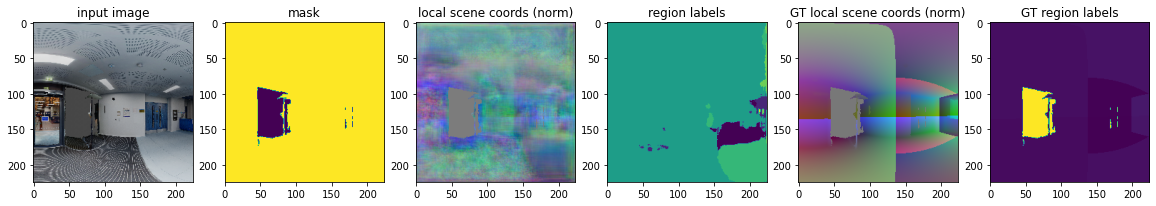

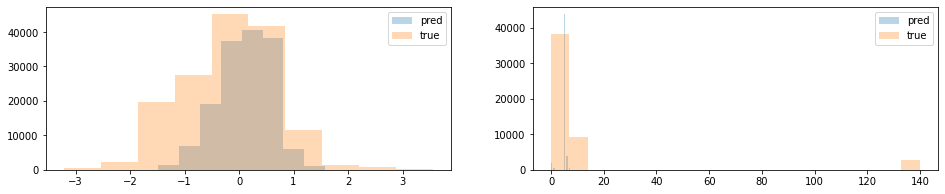

Epoch 151/500
1/1 [==============================] - 0s 3ms/step - loss: 0.3856
MSE:  1.4729613241701267
Epoch 152/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3816
MSE:  1.4703382941267165
Epoch 153/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3776
MSE:  1.4671091806615297
Epoch 154/500
1/1 [==============================] - 0s 3ms/step - loss: 0.3738
MSE:  1.464211756933169
Epoch 155/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3700
MSE:  1.4604815313068786
Epoch 156/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3663
MSE:  1.4565520403527368
Epoch 157/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3627
MSE:  1.452703194549315
Epoch 158/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3591
MSE:  1.4496574135683156
Epoch 159/500
1/1 [==============================] - 0s 2ms/step - loss: 0.3556
MSE:  1.4462736037686927
Epoch 160/500
1/1 [==============================] - 0s 2

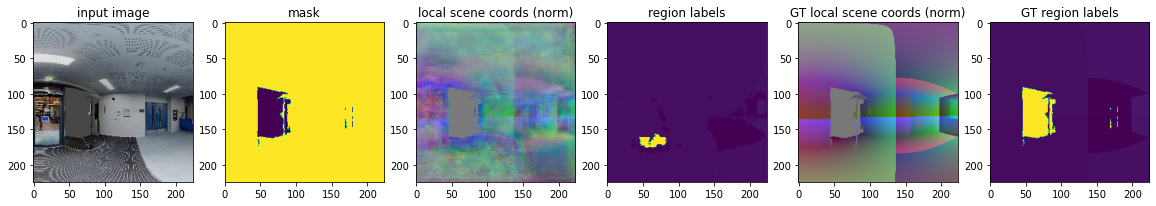

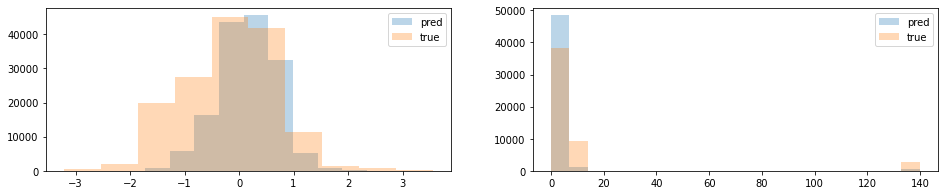

Epoch 201/500
1/1 [==============================] - 0s 1ms/step - loss: 0.2546
MSE:  1.3340496951758403
Epoch 202/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2529
MSE:  1.3301575940091366
Epoch 203/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2513
MSE:  1.3272721476515168
Epoch 204/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2496
MSE:  1.3230119180204656
Epoch 205/500
1/1 [==============================] - 0s 3ms/step - loss: 0.2480
MSE:  1.3195971666813704
Epoch 206/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2464
MSE:  1.3160507948945694
Epoch 207/500
1/1 [==============================] - 0s 3ms/step - loss: 0.2449
MSE:  1.3134138385975092
Epoch 208/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2433
MSE:  1.3088706842157627
Epoch 209/500
1/1 [==============================] - 0s 2ms/step - loss: 0.2418
MSE:  1.3058701986341181
Epoch 210/500
1/1 [==============================] - 0s

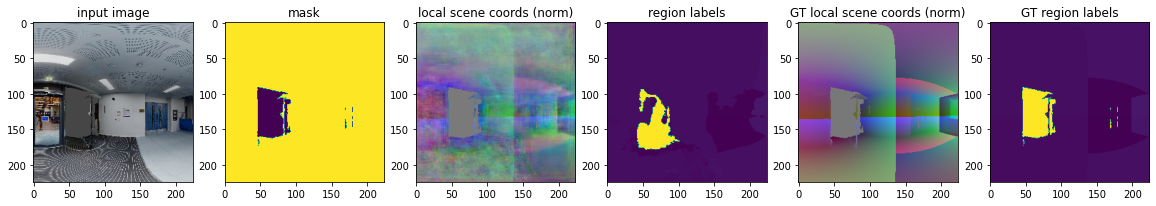

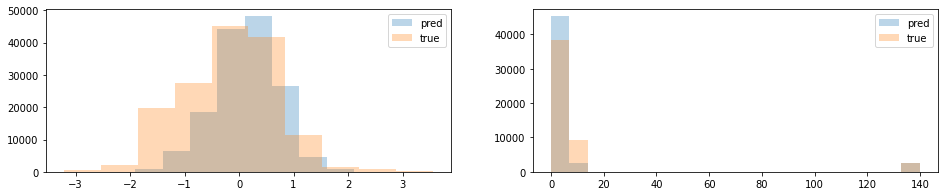

Epoch 251/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1923
MSE:  1.1301353133963257
Epoch 252/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1913
MSE:  1.1211417982713696
Epoch 253/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1904
MSE:  1.1112655424261526
Epoch 254/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1895
MSE:  1.1022608765116373
Epoch 255/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1887
MSE:  1.0934683041085316
Epoch 256/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1878
MSE:  1.0851232842812055
Epoch 257/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1869
MSE:  1.0762111182846696
Epoch 258/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1860
MSE:  1.0663418368455084
Epoch 259/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1852
MSE:  1.056625178280933
Epoch 260/500
1/1 [==============================] - 0s 

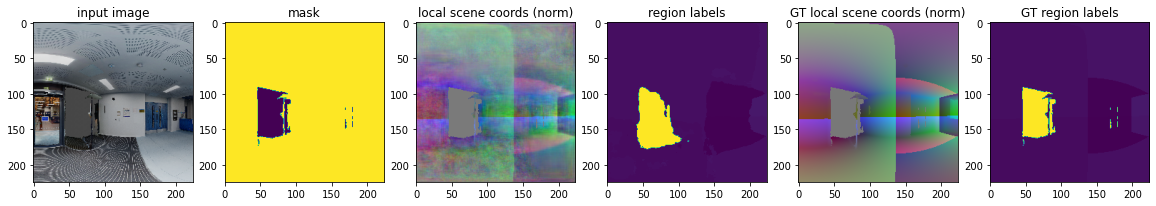

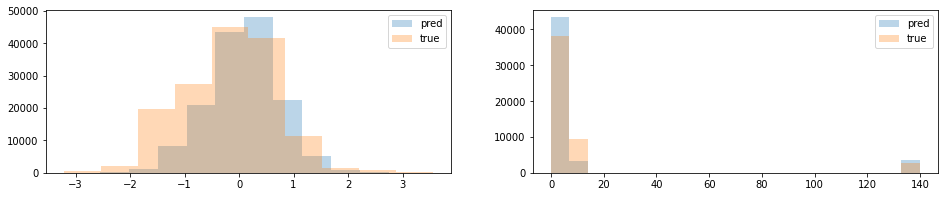

Epoch 301/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1556
MSE:  0.6025683438748174
Epoch 302/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1551
MSE:  0.5943105201650303
Epoch 303/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1545
MSE:  0.5848868926943691
Epoch 304/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1539
MSE:  0.5740728435418788
Epoch 305/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1534
MSE:  0.5635381465445747
Epoch 306/500
1/1 [==============================] - 0s 9ms/step - loss: 0.1528
MSE:  0.5538988483964798
Epoch 307/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1522
MSE:  0.5450736094665003
Epoch 308/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1517
MSE:  0.5353343524725094
Epoch 309/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1511
MSE:  0.5250259192159646
Epoch 310/500
1/1 [==============================] - 0s

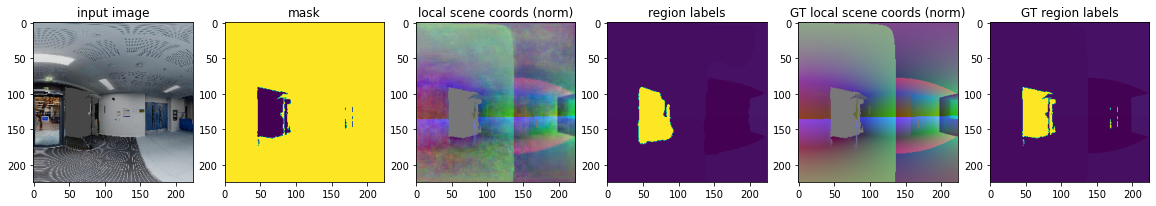

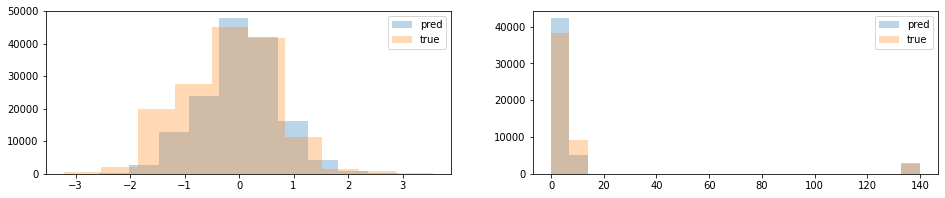

Epoch 351/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1315
MSE:  0.2568893390012475
Epoch 352/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1311
MSE:  0.25442386533943595
Epoch 353/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1307
MSE:  0.2523732713544839
Epoch 354/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1303
MSE:  0.24994755554717624
Epoch 355/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1299
MSE:  0.24668507778324553
Epoch 356/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1295
MSE:  0.24513599247704626
Epoch 357/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1291
MSE:  0.24306659261605063
Epoch 358/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1287
MSE:  0.24024067230794233
Epoch 359/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1283
MSE:  0.23561761370114473
Epoch 360/500
1/1 [=============================

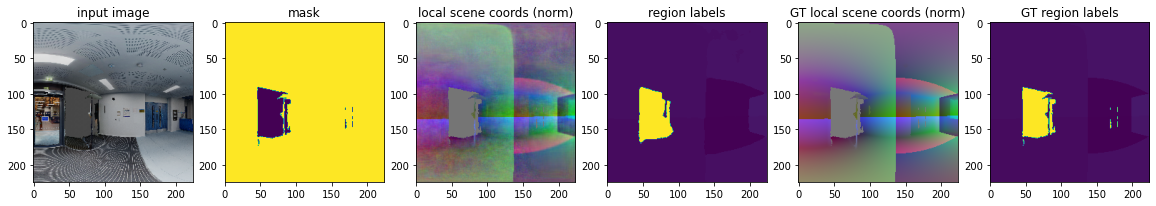

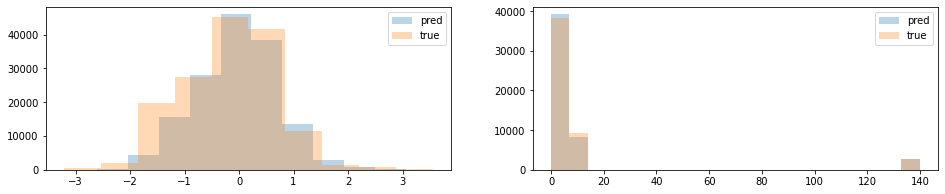

Epoch 401/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1141
MSE:  0.14118332473534703
Epoch 402/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1138
MSE:  0.13942678392390934
Epoch 403/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1135
MSE:  0.1379449295421449
Epoch 404/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1132
MSE:  0.1353069047811697
Epoch 405/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1130
MSE:  0.13359247957864803
Epoch 406/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1127
MSE:  0.13176444303071586
Epoch 407/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1124
MSE:  0.13011955503900946
Epoch 408/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1121
MSE:  0.12806406955857255
Epoch 409/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1118
MSE:  0.1269370037302048
Epoch 410/500
1/1 [==============================

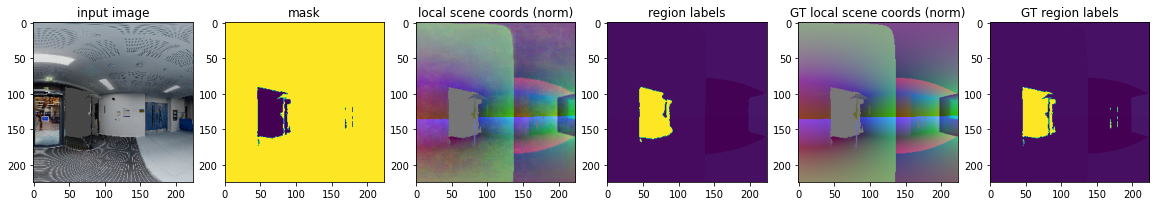

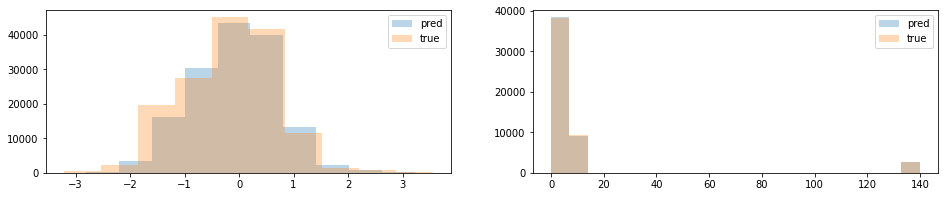

Epoch 451/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1011
MSE:  0.07858141530133432
Epoch 452/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1008
MSE:  0.07786550767070728
Epoch 453/500
1/1 [==============================] - 0s 1ms/step - loss: 0.1006
MSE:  0.07680755277530289
Epoch 454/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1004
MSE:  0.07599363180114578
Epoch 455/500
1/1 [==============================] - 0s 2ms/step - loss: 0.1001
MSE:  0.07510300025088824
Epoch 456/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0999
MSE:  0.0744903901856418
Epoch 457/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0997
MSE:  0.07343558851711872
Epoch 458/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0995
MSE:  0.07245086877543643
Epoch 459/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0993
MSE:  0.07168437975393087
Epoch 460/500
1/1 [============================

In [15]:
fit_configs = {'epochs': 500, 
               'verbose': 1}

history = unet_model.fit([images, mask], labels, callbacks=[callbacks], **fit_configs) #, callbacks=callback

# Evaluate model

In [ ]:
label_pred = unet_model.predict([images, mask])

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16,3))

ax1.imshow(images[0])
ax1.set_title("input image")

ax2.imshow(mask[0,:,:,0])
ax2.set_title("mask")

tmp = (label_pred[0,:,:,:3] - label_pred[0,:,:,:3].min()) / (label_pred[0,:,:,:3].max() - label_pred[0,:,:,:3].min())
ax3.imshow(tmp)
ax3.set_title("local scene coords (normalised)")

ax4.imshow(np.argmax(label_pred[0,:,:,3:], axis=-1))
ax4.set_title("region labels")
plt.show()

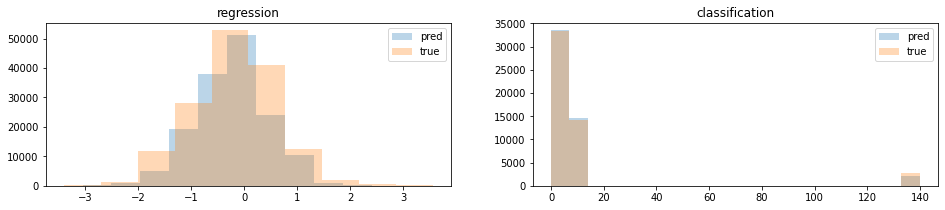

In [124]:
# visualise distribution of TRUE and PRED
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))

ax1.hist(np.reshape(label_pred[0,:,:,:3], (-1)), label="pred", alpha=0.3)
ax1.hist(np.reshape(labels[0,:,:,:3], (-1)), label="true", alpha=0.3)
ax1.set_title('regression')
ax1.legend()

ax2.hist(np.reshape(np.argmax(label_pred[0,:,:,3:], axis=-1), (-1)), label="pred", alpha=0.3, bins=20)
# ax2.hist(np.reshape(np.argmax(labels[0,:,:,3:], axis=-1), (-1)), label="true", alpha=0.3)
ax2.hist(np.reshape(labels[0,:,:,3:], (-1)), label="true", alpha=0.3, bins=20)
ax2.set_title('classification')
ax2.legend()
plt.show()

# Unwhiten predicted coordinates

# Predict pose

# Debugging code

### getting outputs of individual layers

In [ ]:
extractor = keras.Model(inputs=unet_model.inputs,
                        outputs=[unet_model.output for layer in unet_model.layers])

In [ ]:
output = extractor(images)
output[-1].numpy()[0,0,0,:]

### test loss function utside of NN

In [55]:
gen_mask_ = np.expand_dims(gen_mask, axis=-1)
gen_mask_.shape

(1, 224, 224, 1)

In [71]:
labels_pred = np.zeros((1,224,224,8))
labels_pred[:,:,:,:] = 1/8

labels_true = np.zeros((1,224,224,8))
labels_true[:,:,:,0] = 1
# mask = np.ones((1,224,224,1))
labels_true = np.concatenate([labels_true, gen_mask_], axis=-1)
labels_true.shape

(1, 224, 224, 9)

In [72]:
a = masked_X_entropy(labels_true, labels_pred)
a.numpy()

tf.Tensor(
[[[2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  ...
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]
  [2.07944154 2.07944154 2.07944154 ... 2.07944154 2.07944154 2.07944154]]], shape=(1, 224, 224), dtype=float64)


array([[[2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        ...,
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154],
        [2.07944154, 2.07944154, 2.07944154, ..., 2.07944154,
         2.07944154, 2.07944154]]])

In [73]:
np.unique(a.numpy())

array([0.        , 2.07944154])

(array([2.4000e+01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0152e+04]),
 array([0.        , 0.20794415, 0.41588831, 0.62383246, 0.83177662,
        1.03972077, 1.24766493, 1.45560908, 1.66355323, 1.87149739,
        2.07944154]),
 <BarContainer object of 10 artists>)

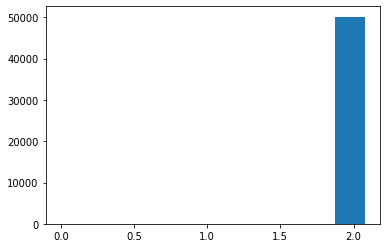

In [74]:
plt.hist(a.numpy().flatten())

In [18]:
tf.keras.losses.categorical_crossentropy(labels_pred, labels_true[:,:,:,:8])

<tf.Tensor: shape=(1, 224, 224), dtype=float64, numpy=
array([[[14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        ...,
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371],
        [14.10333371, 14.10333371, 14.10333371, ..., 14.10333371,
         14.10333371, 14.10333371]]])>

## $\color{red}{\text{CONCLUSION:}}$
### there were 3 errors:

**1. cross entropy outputed 2D matrix rather than scalar** Loss in general should be a scalar. If it's a vector you might compute an update with respect to each element of loss which could grow quicker than for a mean. There would be batch_size*224*224 updates

**2. I was applying softmax function twice** After deleting the first softmax model was fixed. The first softmax could be applied for all nodes 224x224x8 rather than just along the axis=-1

**3. there is some issue with the way i apply the mask** 